## Target Distribution & class imbalance

## context 
class imbalance is the defining characteristic of fraud detection problems. with only approximately 3.5% fraudulent transaction, naive models will simply predict not fraud for everthing and achieve 96 % accuracy while being completly useless in practice

## objective 
- quantify the exact class imbalance ratio
- analyze how fraud distributes accros key features 
- explore temporal pattern in fraud occurrence
- establish strategies for training and evaluation under imbalance

In [ ]:
# import 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

train = pd.read_parquet('../data/interim/train_merged.parquet')
print(f'data loaded :{train.shape}')

Target Distribution : 
Not fraud = 569,877 (96.50%)
Fraud : 569,877 (3.50%)
Imbalanced Ratio : 27:1


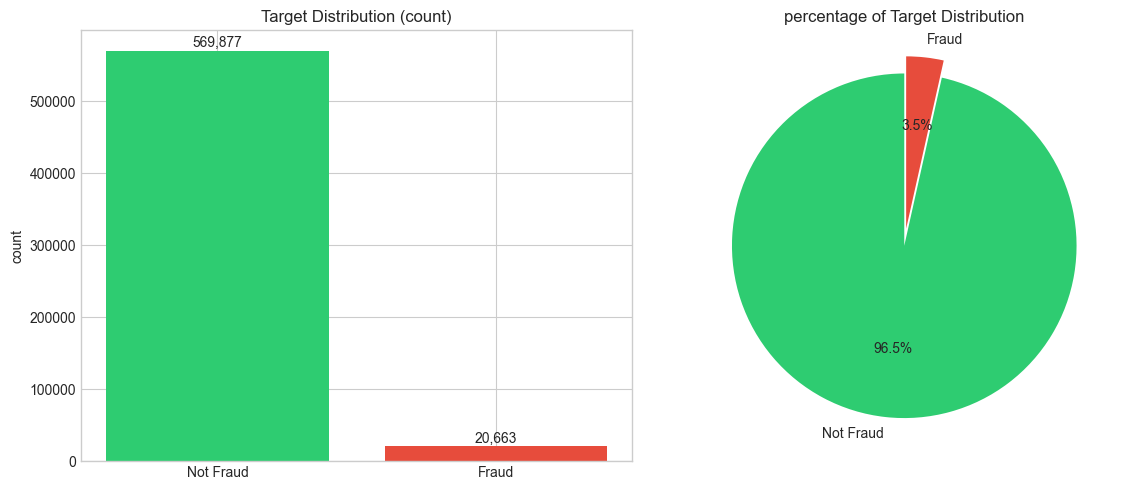

In [2]:
# target distribution
fraud_counts = train['isFraud'].value_counts()
fraud_pct = train['isFraud'].value_counts(normalize=True) * 100

print('Target Distribution : ')
print(f'Not fraud = {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)')
print(f'Fraud : {fraud_counts[0]:,} ({fraud_pct[1]:.2f}%)')
print(f'Imbalanced Ratio : {fraud_counts[0] // fraud_counts[1]}:1')

fig, axes = plt.subplots(1,2,figsize=(12,5))
axes[0].bar(['Not Fraud', 'Fraud'],
            fraud_counts.values,
            color = ['#2ecc71', '#e74c3c'])
axes[0].set_title('Target Distribution (count)')
axes[0].set_ylabel('count')
for i,  v in enumerate(fraud_counts.values):
    axes[0].text(i, v + 5000, f'{v:,}', ha='center')

axes[1].pie(fraud_pct.values,
            labels=['Not Fraud', 'Fraud'],
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            startangle=90,
            explode=[0,0.1]
            )
axes[1].set_title('percentage of Target Distribution')
plt.tight_layout()
plt.show()

    

## Insight :  Understanding the imbalance

from the result we can quantify the challenge we are facing: 

- ~3.5 positive rate : approximately 20.663 fraud cases out of 590.540
- 27:1 imbalance ratio : this is a significant but managable with proper technique
- enough positive sample ( 20k ) : we have sufficient fraud case for robust model training 

this level of imbalance requires metric awarness but doesnt necessitate aggresive oversampling technique like smote, which often hurt generalization performance 

Fraud Rate by Product Code :
            Count  Fraud Count  Fraud Rate
ProductCD                                 
C           68519         8008   11.687269
S           11628          686    5.899553
H           33024         1574    4.766231
R           37699         1426    3.782594
W          439670         8969    2.039939


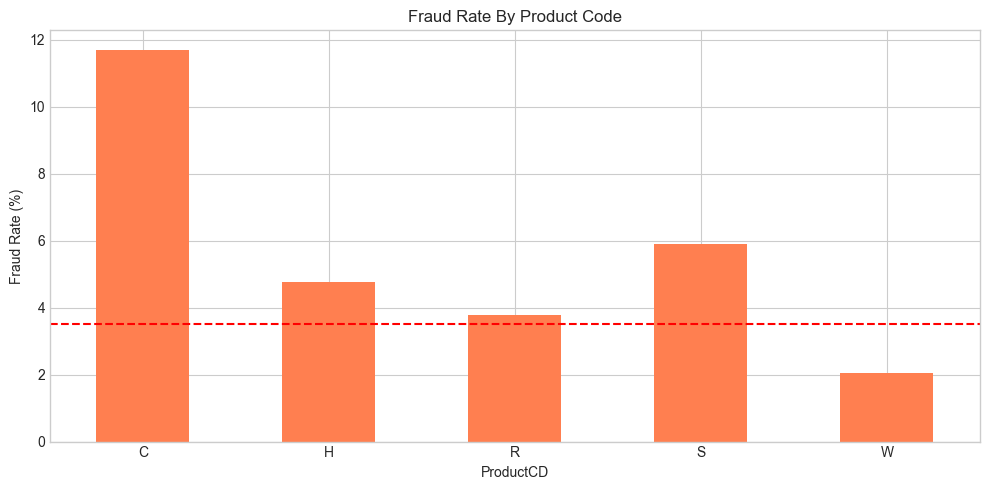

In [3]:
## fraud by product code

product_fraud = train.groupby('ProductCD')['isFraud'].agg(['count','sum','mean'])
product_fraud.columns = ['Count', 'Fraud Count', 'Fraud Rate']
product_fraud['Fraud Rate'] = product_fraud['Fraud Rate'] * 100

print('Fraud Rate by Product Code :')
print(product_fraud.sort_values('Fraud Rate', ascending=False).to_string())

fig, ax = plt.subplots(figsize=(10,5))
product_fraud['Fraud Rate'].plot(kind='bar',ax=ax, color='coral')
ax.set_ylabel('Fraud Rate (%)')
ax.set_title('Fraud Rate By Product Code')
ax.axhline(y=train['isFraud'].mean()*100, color='red', linestyle='--', label='Overal')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## INSIGHT: Fraud Rates by Product Code

- Fraud rates differ substantially across product types.
- ProductCD = C shows the highest fraud rate (~11.6%), followed by S (~5.8%), indicating higher-risk segments.
- This separation suggests that product-specific behaviors exist and can be leveraged by the model.
- Consider using ProductCD-aware features (e.g., amt_vs_product_mean, card_product_interaction) and, if appropriate, segment-aware modeling/stacking.

Fraud rate by Transaction Amount
                      count      mean
amt_bin                              
(0.25, 25.95]         59511  5.588883
(25.95, 35.95]        61650  3.205191
(35.95, 49.0]         65116  3.225014
(49.0, 57.95]         59647  1.943099
(57.95, 68.769]       49346  2.851295
(68.769, 100.0]       73349  3.616955
(100.0, 117.0]        72079  1.974223
(117.0, 159.95]       32399  4.302602
(159.95, 275.293]     58390  3.803734
(275.293, 31937.391]  59053  5.086956


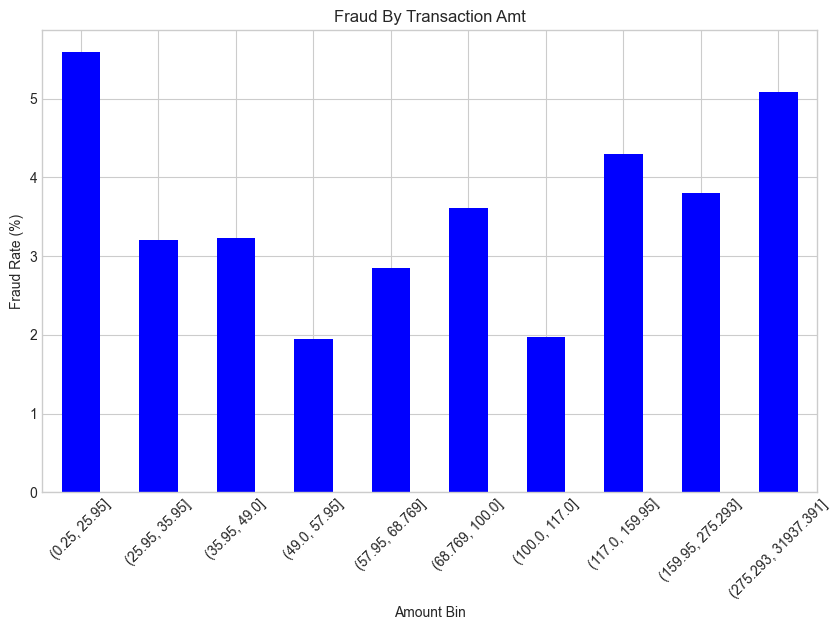

In [4]:
# fraud by transactionamt 
train['amt_bin'] = pd.qcut(train['TransactionAmt'],
                           q=10,
                           duplicates='drop')
amt_fraud = train.groupby('amt_bin')['isFraud'].agg(['count','mean'])
amt_fraud['mean'] = amt_fraud['mean']*100

print('Fraud rate by Transaction Amount')
print(amt_fraud.to_string())

fig, ax = plt.subplots(figsize=(10,6))
amt_fraud['mean'].plot(kind='bar', ax= ax , color = 'blue')
ax.set_title('Fraud By Transaction Amt')
ax.set_ylabel('Fraud Rate (%)')
ax.set_xlabel('Amount Bin')
ax.tick_params(axis='x', rotation=45)

# Insight: Amount-Based Fraud Pattern

From the analysis results, we observe interesting fraud patterns related to transaction amounts:

## Key Findings

- **Bimodal Distribution**: Very small amounts (indicating card testing behavior) and medium-to-high amounts show elevated fraud rates
- **Round Dollar Amounts**: Transactions with round dollar amounts may indicate automated or bot-driven activity
- **Log Transformation**: Applying log transformation helps the model handle highly skewed amount distributions

## Feature Engineering Ideas

The following features can be derived from transaction amounts to improve fraud detection:

1. **TransactionAmt_log**: Apply logarithmic transformation to handle skewness in the amount distribution
2. **is_round_amount**: Binary flag for amounts ending in .00 (e.g., $50.00, $100.00)
3. **TransactionAmt_decimal**: Extract the decimal portion to detect patterns in cent values

## Implementation Notes

These engineered features can help capture:
- Card testing patterns (very small transactions)
- Automated fraud attempts (round amounts)
- Non-human transaction behavior (unusual decimal patterns)

In [ ]:
## class weight strategy
n_neg = (train['isFraud']== 0).sum()
n_pos = (train['isFraud'] == 1 ).sum()
scale_pos_weight = n_neg / n_pos 

print('Class Weighting Strategy :')
print(f'\nNegative Sample : {n_neg:,}')
print(f'Positive Sample : {n_pos:,}')
print(f'\nRecomend  scale_post_weight : {scale_pos_weight}')
print('\nUsage in LightGBM/XGboost:')
print(f"params['scale_pos_weight'] = {scale_pos_weight:.0f}")



Class Weighting Strategy :

Negative Sample : 569,877
Positive Sample : 20,663

Recomend  scale_post_weight : 27.579586700866283

Usage in LightGBM/XGboost:
params['scale_pos_weight'] = 28


## Insigh :Handling Imbalance in training

from the weighting analysis, we recommend these strategies:
- scale_pos_weight in LightGBM/XGBoost : set to n_negative / n_positive 
- class_Weight='balanced' in sklearn models : autamtically computes the ratio
- avoid smote for large dataset : it is computatuinally expensive and often unnecessary with proper weighting

class weighitng directly adjust the lost function, making missclassification of minority classs more costly.  this is more efficient than resampling aproaches

## key takeaways

from the target distribution and imbalance anaylysis:
1. imbalance is severe but manageable : 27:1 with ~20k positive samples
2. fraud concetrates in specific segment : ProductCD 'W' has highest fraud rate
3. use appropriate metrics : ROC-AUC measures ranking ability, PR-AUC focuses on minority class, accuracy is meaningless
4. class weighting is the first line of defense : scale_pos_weight handless imbalance naturally without resampling overhead